# RNN model for Sentiment Analysis

## Methods
- display_confusion_matrix
- save_complete_model
- preprocess_data
- create_rnn_model
- train_and_evaluate
- plot_training_history

In [39]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, GRU, Dense, BatchNormalization, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from keras.optimizers import *
import time
import os
import datetime
import json

base_path = "/home/subha/aiwork/project"


def display_confusion_matrix(confusion_matrix, 
                           labels=['Negative', 'Positive'],
                           title='Confusion Matrix',
                           figsize=(10, 8),
                           normalize=False,
                           cmap='Blues',
                           save_path=None):
    """
    Display a confusion matrix with annotations and metrics
    
    Args:
        confusion_matrix: 2x2 numpy array containing confusion matrix values labels: List of labels for classes
        (default: ['Negative', 'Positive'])
        title: Title for the plot (default: 'Confusion Matrix') figsize: Tuple for figure size (default: (10, 8))
        normalize: Whether to normalize values to percentages (default: False) cmap: Color map for the heatmap (default: 'Blues')
        save_path: Path to save the figure (default: None)
        
    Returns:
        matplotlib figure object
    """
    # Create figure and axes
    fig, ax = plt.subplots(figsize=figsize)
    
    # Normalize matrix if requested
    if normalize:
        confusion_matrix = (confusion_matrix.astype('float') / 
                          confusion_matrix.sum(axis=1)[:, np.newaxis])
        fmt = '.2%'
    else:
        fmt = 'd'
    
    # Create heatmap
    sns.heatmap(confusion_matrix, 
                annot=True,            # Show numbers in cells
                fmt=fmt,               # Number format
                cmap=cmap,             # Color scheme
                square=True,           # Square cells
                xticklabels=labels,    # X-axis labels
                yticklabels=labels,    # Y-axis labels
                ax=ax)                 # Axis to plot on
    
    # Calculate metrics
    tn, fp, fn, tp = confusion_matrix.ravel()
    total = tn + fp + fn + tp
    
    # Calculate key metrics
    accuracy = (tp + tn) / total
    precision = tp / (tp + fp) if (tp + fp) != 0 else 0
    recall = tp / (tp + fn) if (tp + fn) != 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
    
    # Add metrics text
    metrics_text = (
        f'Accuracy: {accuracy:.3f}\n'
        f'Precision: {precision:.3f}\n'
        f'Recall: {recall:.3f}\n'
        f'F1 Score: {f1:.3f}'
    )
    
    # Add metrics box
    props = dict(boxstyle='round', facecolor='white', alpha=0.8)
    ax.text(1.5, 0.5, metrics_text,
            transform=ax.transAxes,
            bbox=props,
            fontsize=10,
            verticalalignment='center')
    
    # Customize plot
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    plt.title(title)
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()

    #plt.show()
    
    # # Save figure if path provided
    # if save_path:
    #     plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    return fig

def save_complete_model(model, model_type, custom_name=None):
    """
    Save the complete model including architecture, weights, and optimizer state
    
    Args:
        model: Keras model instance
        model_type (str): Type of the model
        custom_name (str, optional): Custom name for the model
        
    Returns:
        str: Path to the saved model
    """
    try:
        epoch_time = str(int(time.time()))
        model_name = f"{custom_name}_{epoch_time}.keras"
        save_path = os.path.join(base_path, "complete_models",custom_name)
        model_path = os.path.join(save_path,model_name)
        
        # Save the complete model
        model.save(model_path)
        
        # Save additional metadata
        metadata = {
            "model_type": model_type,
            "save_date": datetime.datetime.now().isoformat(),
            "keras_version": tf.keras.__version__,
            "model_name": model_name
        }
        
        metadata_path = os.path.join(save_path, f"metadata_{epoch_time}.json")
        with open(metadata_path, 'w') as f:
            json.dump(metadata, f, indent=4)
            
        print(f"Model successfully saved to: {save_path}")
        return save_path
        
    except Exception as e:
        print(f"Error saving complete model: {str(e)}")
        raise

def preprocess_data(texts, labels, max_words=10000, max_len=100):
    """
    Preprocess text data for RNN input
    """
    # Tokenize texts
    tokenizer = Tokenizer(num_words=max_words)
    tokenizer.fit_on_texts(texts)
    
    # Convert texts to sequences
    sequences = tokenizer.texts_to_sequences(texts)
    
    # Pad sequences
    padded_sequences = pad_sequences(sequences, maxlen=max_len)
    
    return padded_sequences, tokenizer


def create_rnn_model(rnn_type, max_words=10000, max_len=100, embedding_dim=100):
    """
    Create RNN model based on specified type
    """
    print("=======================================================================================")
    print("I am in create_rnn_model")
    print("=======================================================================================")

    model = Sequential(name=rnn_type)
    model.add(Embedding(max_words, embedding_dim))
    
    # adding a LSTM layer 
    if rnn_type == 'simple':
        model.add(SimpleRNN(32, activation='relu'))
    elif rnn_type == 'lstm':## Add with attention
        model.add(LSTM(32, return_sequences=False))
    elif rnn_type == 'bilstm':
        # Add Bidirectional LSTM with attention
        model.add(Bidirectional(LSTM(32, return_sequences=True)))
        # Attention mechanism
        model.add(Attention())
    else :
        model.add(GRU(32))
    BatchNormalization()
    model.add(Dropout(0.5))
    
    #adding a dense layer with activation function of relu
    model.add(Dense(16, activation='relu'))
    BatchNormalization()
    model.add(Dropout(0.5))
    
    # adding the final output activation with activation function of softmax
    model.add(Dense(1, activation='sigmoid'))

    optimizer = Adam(learning_rate=0.001)
    
    model.compile(optimizer=optimizer,
                 loss='binary_crossentropy',
                 metrics=['accuracy'])
    #model.summary()
    
    return model

def train_and_evaluate(model, X_train, y_train, X_val, y_val, X_test, y_test, rnn_type, epochs=10):
    """
    Train model and evaluate performance
    """

    print("=======================================================================================")
    print("I am in train_and_evaluate")
    print("=======================================================================================")
    # Early stopping to prevent overfitting
    early_stopping = EarlyStopping(monitor='val_loss', 
                                 patience=3,
                                 restore_best_weights=True)
    
    # Train model

    history = model.fit(X_train, 
                        y_train,
                        #batch_size=32,
                       epochs=epochs,
                       verbose=1,
                       validation_data=(X_val, y_val)
                       )
    #,
    #callbacks=[early_stopping]
    
    # Evaluate on test set
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    
    model.summary()
    
    save_path = save_complete_model(
                        model=model,
                        model_type=rnn_type,
                        custom_name=f"sentiment_analysis_{rnn_type}"
                    )
    print(f"The Model is saved in {save_path}")
    
    # Generate predictions
    y_pred = (model.predict(X_test) > 0.5).astype(int)
    
    return history, test_loss, test_accuracy, y_pred

def plot_training_history(history, model_name):
    """
    Plot training and validation metrics
    """
    print("=======================================================================================")
    print("I am in plot_training_history")
    print("=======================================================================================")
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # Plot accuracy
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_title(f'{model_name} - Accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Validation'])
    
    # Plot loss
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title(f'{model_name} - Loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Validation'])
    
    plt.tight_layout()
    return fig

## Attention Layer (Still Testing)

In [38]:
# Attention layer implementation
class Attention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)
        
    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1),
                                 initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1),
                                 initializer="zeros")
        self.u = self.add_weight(name="att_u", shape=(input_shape[-1],),
                                 initializer="glorot_uniform", trainable=True),
        super(Attention, self).build(input_shape)
        
    def call(self, x):
        # Alignment scores. e = tanh(Wx + b)
        e = tf.tanh(tf.dot(x, self.W) + self.b)
        
        # Remove dimension of size 1
        e = tf.squeeze(e, axis=-1)
        
        # Compute the weights
        alpha = tf.softmax(e)
        
        # Reshape to match the dimensions
        alpha = tf.expand_dims(alpha, axis=-1)
        
        # Weighted sum
        context = x * alpha
        context = tf.sum(context, axis=1)
        
        return context

## Compare Models

In [41]:
def compare_models(X_train, y_train, X_val, X_test, y_val, y_test):
    """
    Compare different RNN architectures
    """

    results = {}
    model_types = ['simple', 'lstm', 'gru']
    #model_types = ['bilstm']
    
    for rnn_type in model_types:
        # Create and train model
        model = create_rnn_model(rnn_type)
        history, test_loss, test_accuracy, y_pred = train_and_evaluate(
            model, X_train, y_train, X_val, y_val, X_test, y_test, rnn_type
        )
        
        # Store results
        results[rnn_type] = {
            'history': history,
            'test_loss': test_loss,
            'test_accuracy': test_accuracy,
            'predictions': y_pred,
            'classification_report': classification_report(y_test, y_pred),
            'confusion_matrix': confusion_matrix(y_test, y_pred)
        }

        display_confusion_matrix(confusion_matrix(y_test, y_pred))
        
        # Plot training history
        plot_training_history(history, rnn_type.upper())
        
    return results, tokenizer


## Read Sampled Data 

In [3]:
X_test_ = pd.read_parquet('output/cleandata/test_data_sample/', engine='pyarrow' )
X_train_ = pd.read_parquet('output/cleandata/train_data_sample/', engine='pyarrow' )
X_val_ = pd.read_parquet('output/cleandata/val_data_sample/', engine='pyarrow' )

## Tokenize the Datasets

In [30]:
## Train

X_text_train = list(X_train_["cleaned_text"])
y_train = np.array(X_train_['sentiment']).astype("int32")# X_train_[["sentiment"]]
X_train, tokenizer = preprocess_data(X_text_train, y_train)

## Test

X_text_test = list(X_test_["cleaned_text"])
y_test = np.array(X_test_['sentiment']).astype("int32")# X_train_[["sentiment"]]
X_test, tokenizer = preprocess_data(X_text_test, y_test)

## Val

X_text_val = list(X_val_["cleaned_text"])
y_val = np.array(X_val_['sentiment']).astype("int32")# X_train_[["sentiment"]]
X_val, tokenizer = preprocess_data(X_text_val, y_val)


In [31]:
print(X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape)

(360000, 100) (20055, 100) (19945, 100) (360000,) (20055,) (19945,)


I am in create_rnn_model
I am in train_and_evaluate
Epoch 1/10
11250/11250 ━━━━━━━━━━━━━━━━━━━━ 79s 7ms/step - accuracy: 0.7988 - loss: 0.4358 - val_accuracy: 0.5869 - val_loss: 0.9429
Epoch 2/10
11250/11250 ━━━━━━━━━━━━━━━━━━━━ 76s 7ms/step - accuracy: 0.9007 - loss: 0.2759 - val_accuracy: 0.5873 - val_loss: 1.0959
Epoch 3/10
11250/11250 ━━━━━━━━━━━━━━━━━━━━ 73s 7ms/step - accuracy: 0.9053 - loss: 0.2621 - val_accuracy: 0.5833 - val_loss: 1.2242
Epoch 4/10
11250/11250 ━━━━━━━━━━━━━━━━━━━━ 74s 7ms/step - accuracy: 0.9094 - loss: 0.2576 - val_accuracy: 0.5786 - val_loss: 0.9331
Epoch 5/10
11250/11250 ━━━━━━━━━━━━━━━━━━━━ 73s 7ms/step - accuracy: 0.9031 - loss: 0.2692 - val_accuracy: 0.5772 - val_loss: 1.5912
Epoch 6/10
11250/11250 ━━━━━━━━━━━━━━━━━━━━ 73s 6ms/step - accuracy: 0.9157 - loss: 0.2359 - val_accuracy: 0.5711 - val_loss: 1.2266
Epoch 7/10
11250/11250 ━━━━━━━━━━━━━━━━━━━━ 73s 6ms/step - accuracy: 0.9178 - loss: 0.2313 - val_accuracy: 0.5854 - val_loss: 1.0650
Epoch 8/10
11250/

Model: "simple"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_13 (Embedding)        │ (32, 100, 100)         │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_5 (SimpleRNN)        │ (32, 32)               │         4,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (32, 32)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (32, 16)               │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (32, 16)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (32, 1)                │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,014,405 (11.50 MB)

 Trainable params: 1,004,801 (3.83 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,009,604 (7.67 MB)

Model successfully saved to: /home/subha/aiwork/project/complete_models/sentiment_analysis_simple
The Model is saved in /home/subha/aiwork/project/complete_models/sentiment_analysis_simple
627/627 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
I am in plot_training_history
I am in create_rnn_model
I am in train_and_evaluate
Epoch 1/10
11250/11250 ━━━━━━━━━━━━━━━━━━━━ 118s 10ms/step - accuracy: 0.8626 - loss: 0.3334 - val_accuracy: 0.5891 - val_loss: 1.0014
Epoch 2/10
11250/11250 ━━━━━━━━━━━━━━━━━━━━ 106s 9ms/step - accuracy: 0.9263 - loss: 0.2088 - val_accuracy: 0.5957 - val_loss: 0.8887
Epoch 3/10
11250/11250 ━━━━━━━━━━━━━━━━━━━━ 107s 9ms/step - accuracy: 0.9378 - loss: 0.1793 - val_accuracy: 0.5807 - val_loss: 0.9378
Epoch 4/10
11250/11250 ━━━━━━━━━━━━━━━━━━━━ 106s 9ms/step - accuracy: 0.9475 - loss: 0.1550 - val_accuracy: 0.5768 - val_loss: 1.2462
Epoch 5/10
11250/11250 ━━━━━━━━━━━━━━━━━━━━ 105s 9ms/step - accuracy: 0.9547 - loss: 0.1354 - val_accuracy: 0.5754 - val_loss: 1.3542
Epoch 6/10
11250/

Model: "lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_14 (Embedding)        │ (32, 100, 100)         │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (32, 32)               │        17,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (32, 32)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (32, 16)               │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (32, 16)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (32, 1)                │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,052,709 (11.65 MB)

 Trainable params: 1,017,569 (3.88 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,035,140 (7.76 MB)

Model successfully saved to: /home/subha/aiwork/project/complete_models/sentiment_analysis_lstm
The Model is saved in /home/subha/aiwork/project/complete_models/sentiment_analysis_lstm
627/627 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
I am in plot_training_history
I am in create_rnn_model
I am in train_and_evaluate
Epoch 1/10
11250/11250 ━━━━━━━━━━━━━━━━━━━━ 109s 10ms/step - accuracy: 0.8576 - loss: 0.3354 - val_accuracy: 0.5812 - val_loss: 1.0933
Epoch 2/10
11250/11250 ━━━━━━━━━━━━━━━━━━━━ 103s 9ms/step - accuracy: 0.9290 - loss: 0.1990 - val_accuracy: 0.5812 - val_loss: 1.0375
Epoch 3/10
11250/11250 ━━━━━━━━━━━━━━━━━━━━ 104s 9ms/step - accuracy: 0.9409 - loss: 0.1692 - val_accuracy: 0.5813 - val_loss: 1.0438
Epoch 4/10
11250/11250 ━━━━━━━━━━━━━━━━━━━━ 108s 10ms/step - accuracy: 0.9516 - loss: 0.1460 - val_accuracy: 0.5743 - val_loss: 1.1453
Epoch 5/10
11250/11250 ━━━━━━━━━━━━━━━━━━━━ 108s 10ms/step - accuracy: 0.9589 - loss: 0.1237 - val_accuracy: 0.5745 - val_loss: 1.4159
Epoch 6/10
11250/11

Model: "gru"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_15 (Embedding)        │ (32, 100, 100)         │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (32, 32)               │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (32, 32)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (32, 16)               │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (32, 16)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (32, 1)                │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,040,229 (11.60 MB)

 Trainable params: 1,013,409 (3.87 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,026,820 (7.73 MB)

Model successfully saved to: /home/subha/aiwork/project/complete_models/sentiment_analysis_gru
The Model is saved in /home/subha/aiwork/project/complete_models/sentiment_analysis_gru
627/627 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
I am in plot_training_history


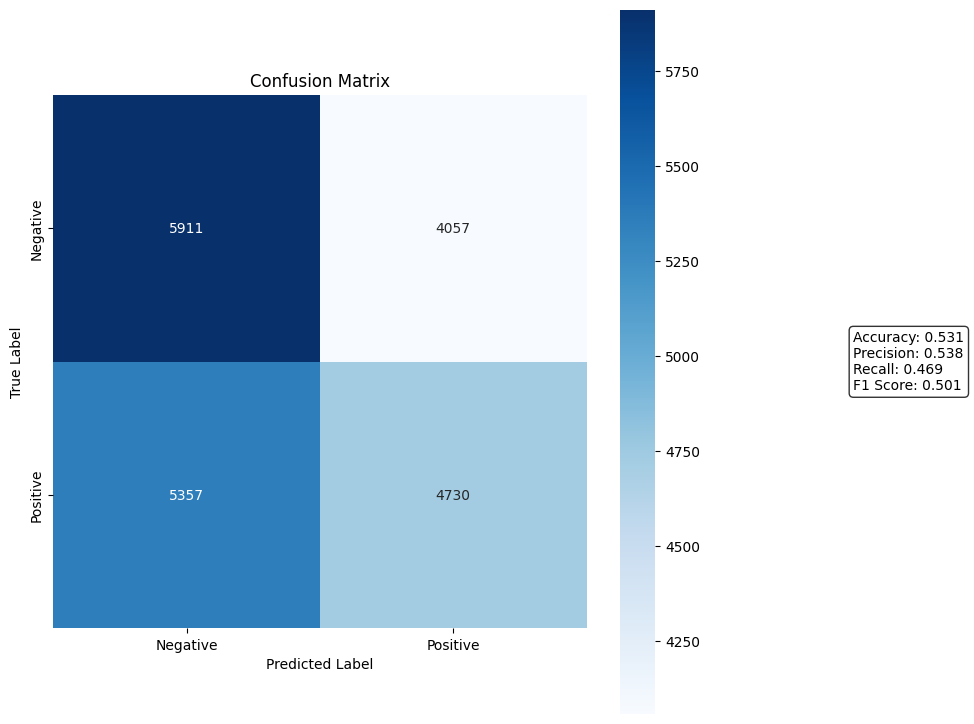

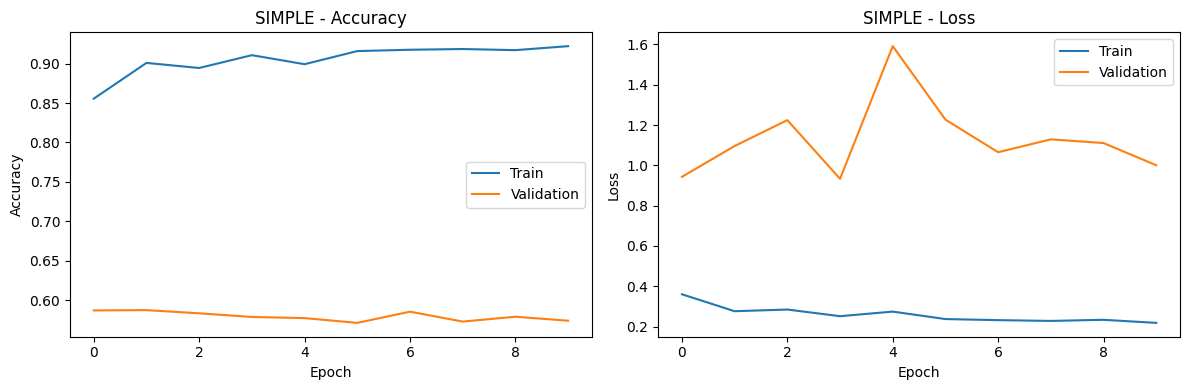

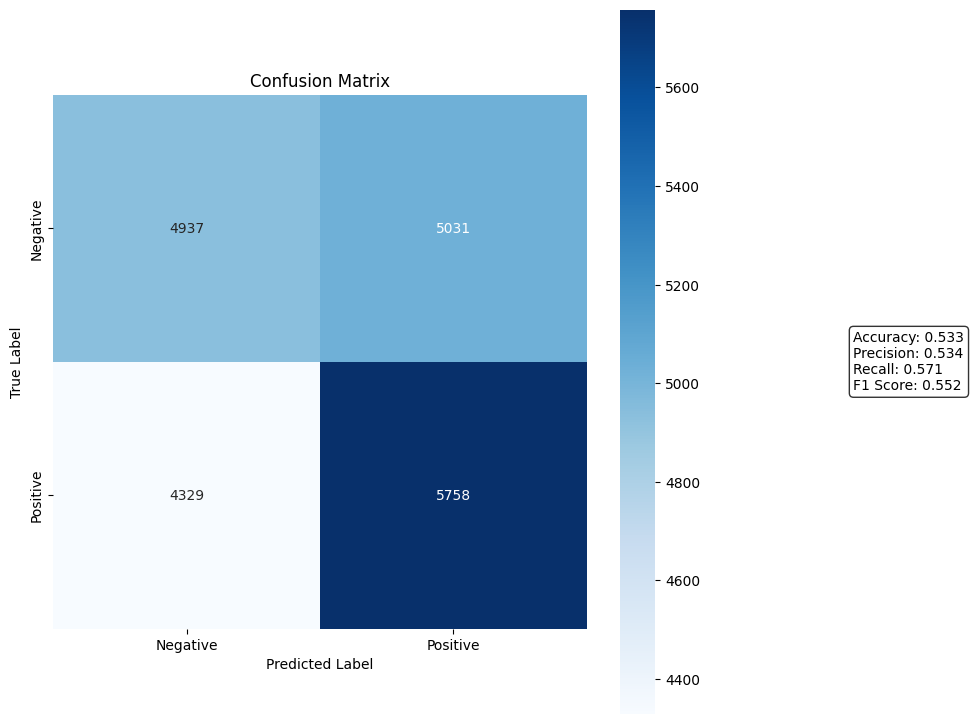

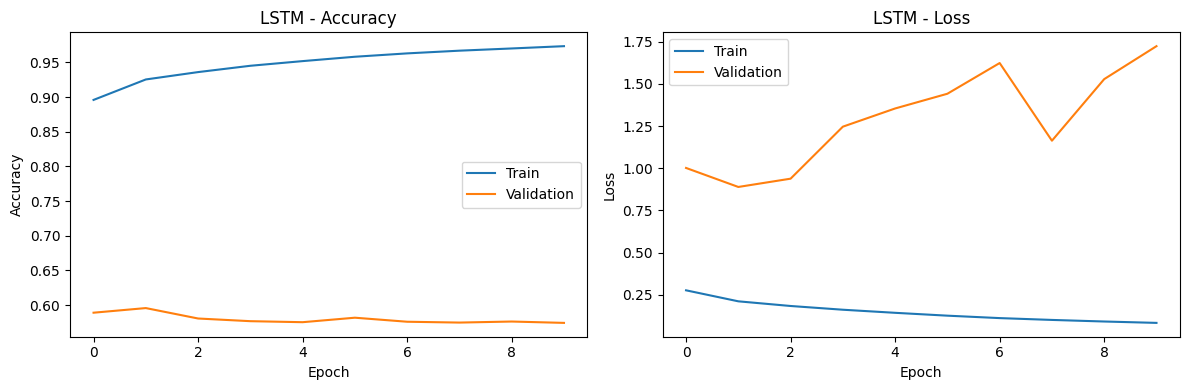

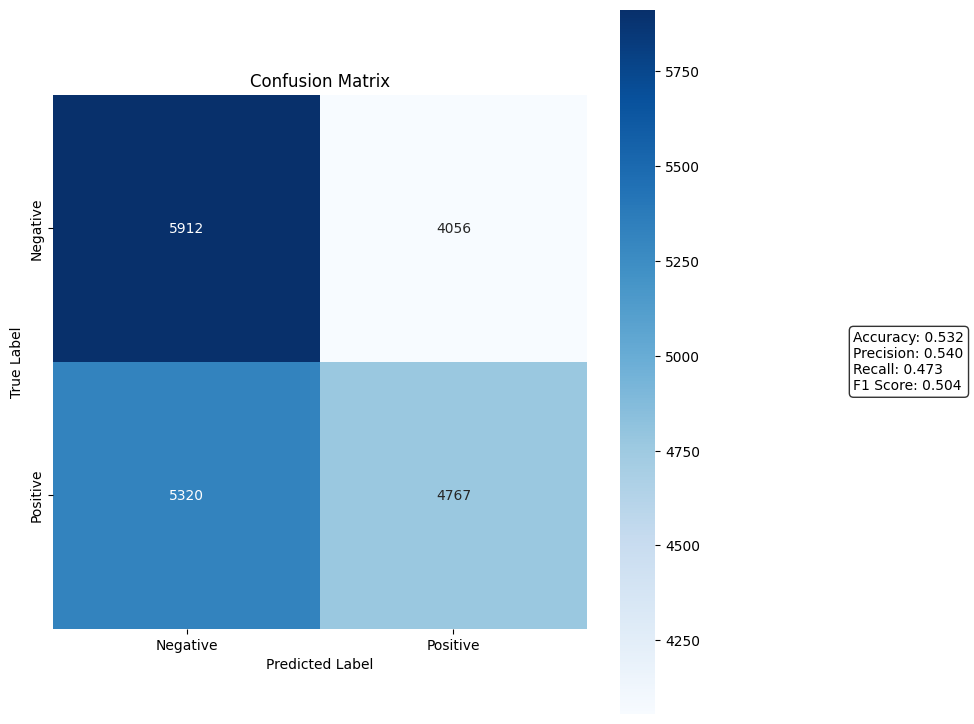

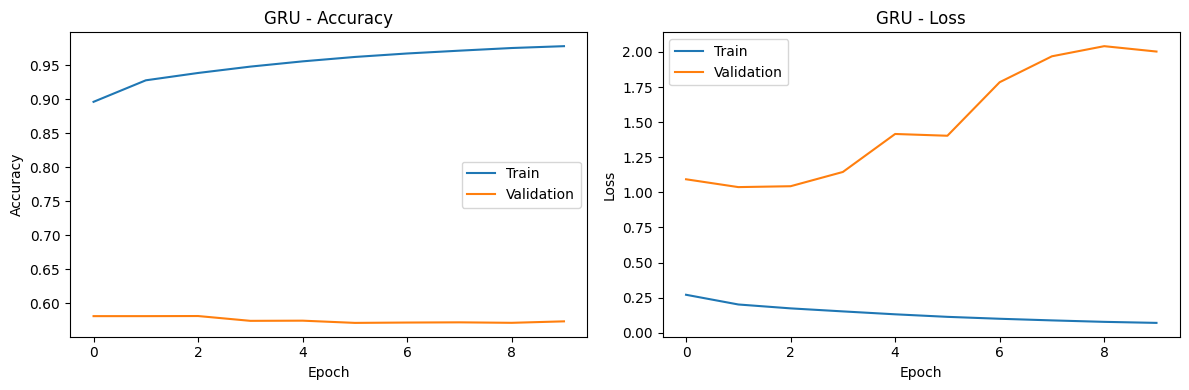

In [42]:
results, tokenizer = compare_models(X_train, y_train, X_val, X_test, y_val, y_test)

## Appendix

In [3]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2025-02-23 13:45:04.700296: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-23 13:45:04.799680: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740336304.842313  133764 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740336304.856052  133764 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-23 13:45:04.961204: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Num GPUs Available:  1


In [67]:
!nvidia-smi

Sun Mar  2 12:33:25 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.86.16              Driver Version: 572.16         CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4070 ...    On  |   00000000:01:00.0 Off |                  N/A |
|  0%   26C    P8              1W /  220W |   11568MiB /  12282MiB |     14%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [8]:
!nvidia-smi  -L

GPU 0: NVIDIA GeForce RTX 4070 SUPER (UUID: GPU-40292fc1-c848-a256-79c7-1ec1a07d8fa8)


In [9]:
!nvidia-smi  -rmc

The current user does not have permission to change clocks for GPU 00000000:01:00.0.
Terminating early due to previous errors.
